# Modeling linear TV reach with Virtual People

evgenys@google.com

September, 2020

In our [whitepaper](https://storage.googleapis.com/pub-tools-public-publication-data/pdf/1ab33ed15e0a7724c7b0b47361da16259fee8eef.pdf) we conver how VID is applied to digital event-level data. Linear TV could be measured with panel, or extrapolated from a set of metered OTT devices, and event data is not available.

In this colab we will be discussing application of  VID to panel data. Application to OTT devices is done analogously.

We discuss two approaches:

**Aggregate)** Given a panel measurement arbitrary aggregate technique is used to do reach estimate in each demographic bucket. Then appropriate amound of virtual people are sampled from the total virtual population of the bucket to match the aggregate estimate.

**VID-native)** Each panelist is consistently hashed to a set of virtual people. To report on an audience one should take a union of all virtual people to which reached panelists hash. Reach is the number of these people.

In both approaches the virtual people can be stored in a sketch and transmitted into the cross media measurement system's secure cardinality estimation framework to be unioned with the digital reach.

The **advantage Aggregate approach** is that
* it is compatible with an arbitrary TV audience measurement methodology and simply encodes it for deduplication with the digital reach.

The **advantages VID-native approach** is that
* it guarantees conistency for TV measurement and
* it may lead to an easier engineering infrastructure.

In the rest of this colab we implement these approaches conceptually and run some simple simulations.

## Creating panel and virtual people pools


We assume have 4 age buckets, each of width 20 years, starting from 20 and ending at a 100. Population distribution is assumed to be equal by bucket. 

We sample panelists from this population and create pools of virtual people with appropriate sizes.


In [ ]:

import hashlib

num_panelists = 100
num_vids = 1000
random_age = lambda x: hash("age-" + str(x)) % 80 + 20

def hash(x):
  return int(hashlib.sha256(x.encode()).hexdigest(), 16)

def hash_all(*elements):
  return hash('-'.join(map(str, elements)))

def float_hash_all(*elements):
  precision = 1000000000
  return (hash_all(*elements) % precision) / precision

def affinity_hash(options, *elements):
  affinities = [float_hash_all(option, *elements) for option in options]
  return options[affinities.index(max(affinities))]

def make_panel():
  panel = list(range(num_panelists))
  panelist_age = {panelist: random_age(panelist) for panelist in panel}
  return panel, panelist_age

def make_virtual_people_by_age():
  offset = 1000000
  virtual_people_for_age_bucket = {}
  age_from = 20
  age_buckets = [(a, a + 20) for a in range(20, 100, 20)]
  for bucket in age_buckets:
    num_people_for_bucket = num_vids // len(age_buckets)
    virtual_people_for_age_bucket[bucket] = list(
        range(offset, offset + num_people_for_bucket))
    offset = offset + num_people_for_bucket
  return virtual_people_for_age_bucket

panel, panelist_age = make_panel()  

people_map = make_virtual_people_by_age()
virtual_person_age_bucket = {
    person: bucket
    for bucket, people in people_map.items()
    for person in people}

all_virtual_people = [p for p in people_map.values()]



In [ ]:
def PanelistAgeBucket(panelist):
  age = panelist_age[panelist]
  for a, b in people_map:
    if a <= age < b:
      return a, b
  assert False, "Unknown age for panelist: " + str(panelist)

total_panel_in_bucket = {}
panelists_of_bucket = {}

for p in panel:
  bucket = PanelistAgeBucket(p)
  total_panel_in_bucket[bucket] = total_panel_in_bucket.get(bucket, 0) + 1
  panelists_of_bucket[bucket] = panelists_of_bucket.get(bucket, []) + [p]



## Aggregate

We implement the aggregate approach with `aggregate_virtual_audience_estimator` class.

The basic estimation function is `create_virtual_audience_from_reach`, which given an arbitrary reach in population buckets samples virtual people from these buckets. We then implement `aggregate_virtual_audience_estimator` by first estiamting the reach in buckets from panel reach and then delegating virtual people sampling to `create_virtual_audience_from_reach`.

It is very important that the core function `create_virtual_audience_from_reach` does not exlicitly depend on the panelists reached. Which means that reach estimation can be done with arbitrary technology.

In [ ]:

def create_virtual_audience_from_reach(
    audience_key, bucket_fraction_reach):
  audience = []
  for bucket in bucket_fraction_reach:
    for person in people_map[bucket]:
      if float_hash_all(
          "audience", audience_key, person) < bucket_fraction_reach[bucket]:
        audience.append(person)
  return audience

def estimate_aggregate_reach(panelists):
  bucket_reach = {}
  for p in panelists:
    bucket = PanelistAgeBucket(p)
    bucket_reach[bucket] = bucket_reach.get(bucket, 0) + 1
  bucket_fraction = {
      bucket: bucket_reach[bucket] / total_panel_in_bucket[bucket]
      for bucket in bucket_reach}
  return bucket_fraction

def create_virtual_audience_with_aggregate_method(audience_key, panelists):
  per_bucket_reach = estimate_aggregate_reach(panelists)
  return create_virtual_audience_from_reach(
      audience_key, per_bucket_reach)

class AggregateVirtualAudienceEstimator(object):
  def __init__(self, seed):
    self.seed = seed

  def estimate_from_panelists(self, audience_key, panelists):
    return create_virtual_audience_with_aggregate_method(
        '%s-%s' % (self.seed, audience_key), panelists)


## VID native

The VID native approach works more similar to how digital reach is estimated. The set of virtual people is assigned to each event. Reach of the set of events
is estimated as the total number of unique virtual people in the union of the sets of virtual people assigned to these events.

To do this assignment for a given time interval we assign each virtual person to a panelist that represents this person. Thus for each panelist we end up with a set of virtual people that this panelist represents. The number of
virtual people assigned to the panelist is to be proportional to the weight of the panelist. Each event of the panelist gets assigned this set of virtual people.

Affinity hashing (a particular form of consistent hashing) is used to do this
assignement. Thus if the weights of the panelist are changing from day to day
the minumal necessary number of virtual people get re-assigned.



In [ ]:
import collections

def map_virtual_people_to_panelists(seed):
  panelist_of_virtual_person = {}
  for bucket, people in people_map.items():
    eligible_panelists = panelists_of_bucket[bucket]
    for person in people:
      panelist_of_virtual_person[person] = affinity_hash(
          eligible_panelists, seed, person)
  return panelist_of_virtual_person

def map_panelists_to_virtual_people(seed):
  vid_to_panelist = map_virtual_people_to_panelists(seed)
  panelist_to_virtual_people = collections.defaultdict(list)
  for vid, panelist in vid_to_panelist.items():
    panelist_to_virtual_people[panelist].append(vid)
  return panelist_to_virtual_people

def create_virtual_audience_with_native_method(
    panelist_to_virtual_people, panelists):
  result = []
  for p in set(panelists):
    result.extend(panelist_to_virtual_people[p])
  return result

class NativeVirtualAudienceEstimator(object):

  def __init__(self, seed):
    self.panelist_to_vids = map_panelists_to_virtual_people(seed)

  def estimate(self, panelists):
    return create_virtual_audience_with_native_method(
        self.panelist_to_vids, panelists)



## Simulation

We run simulations, verifying that the Aggregate and Native methods are estimating the reach and demographic composition accurately.

The following random process is used to generate the audience:
Campaign parameter `size` (roughly correspondning to the total fraction of the population that will be reached) is sampled from uniform [0,1] distribution.

Fraction of each demo bucket reached is sampled from a Beta distribution with expectation equal to `size`.

This process leads to campaigns of different sizes and different demographic skews.

In [ ]:
import numpy
from scipy import stats
from matplotlib import pyplot

def simulate_campaign_bucket_reach(campaign_key):
  size = float_hash_all("SimulateCampaign", campaign_key)
  result = {}
  for bucket in people_map:
    h = float_hash_all("SCBR", campaign_key, bucket)
    bucket_penetration = stats.beta.ppf(h, 5 * size, 5 * (1 - size))
    result[bucket] = bucket_penetration
  return result

def simulate_campaign_panel_reach(campaign_key):
  reached = []
  bucket_reach = simulate_campaign_bucket_reach(campaign_key)
  for bucket, panelists in panelists_of_bucket.items():
    for p in panelists:
      if float_hash_all("SCPR", campaign_key, p) < bucket_reach[bucket]:
        reached.append(p)
  return reached



### Reach

First scattercharts compare the methods to the true reach and to the fraction of the number of panelists reached.

We observe that Aggregate and Native methods produce close results. They are closer to each other than Panel method to the Truth. Note that this is  the case because we used simple panelist counting as the basis estimate for the aggregate method. The advantage of aggregate method is that aribtrary reach
estimation methodology can be used as the basis and it is not necessarily reproducible via the Native method.

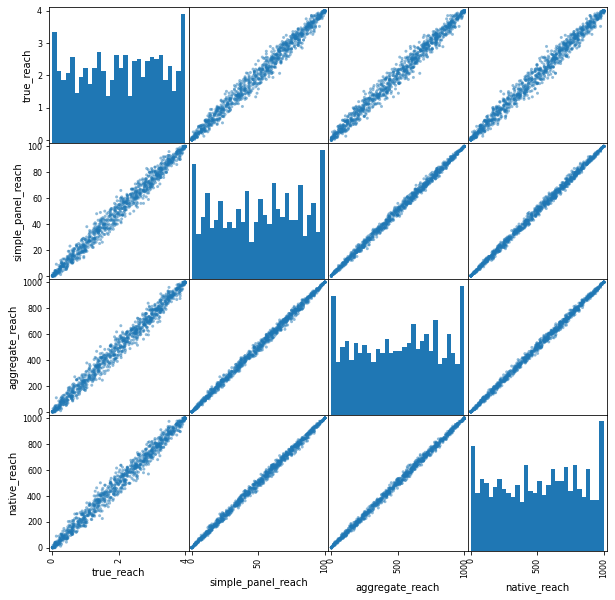

In [ ]:
import pandas
from pandas.plotting import scatter_matrix


num_campaigns = 1000

campaign_true_reach = { 
    "campaign-%d" % i: simulate_campaign_bucket_reach("campaign-%d" % i)
    for i in range(num_campaigns)
}
campaign_panel_reach = {
    "campaign-%d" % i: simulate_campaign_panel_reach("campaign-%d" % i)
    for i in range(num_campaigns)
}

aggregate_reach = []
native_reach = []
true_reach = []
simple_panel_reach = []

native_estimator = NativeVirtualAudienceEstimator(42)
aggregate_estimator = AggregateVirtualAudienceEstimator(42)

for campaign, panelists in campaign_panel_reach.items():
  true_reach.append(sum(campaign_true_reach[campaign].values()))
  native_reach.append(len(native_estimator.estimate(panelists)))
  aggregate_reach.append(
      len(aggregate_estimator.estimate_from_panelists(campaign, panelists)))
  simple_panel_reach.append(
      len(panelists)
  )

df = pandas.DataFrame({'true_reach': true_reach,
                       'simple_panel_reach': simple_panel_reach,
                       'aggregate_reach': aggregate_reach,
                       'native_reach': native_reach})
_ = scatter_matrix(df, figsize=(10, 10), hist_kwds={'bins':30})



### Demographic composition

Next we compare the methods for estimation of the fraction of reach that belongs to the under 60 bucket, which happens to be on average half of the reached audience.

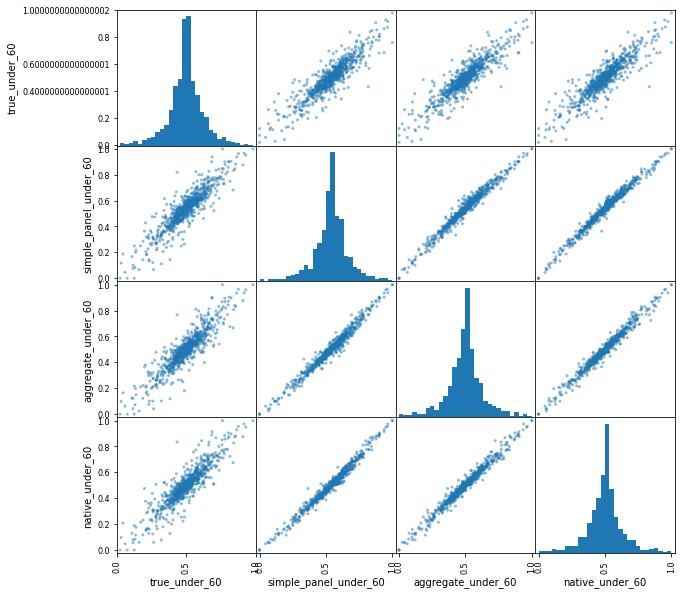

In [ ]:

aggregate_under_60 = []
native_under_60 = []
true_under_60 = []
simple_panel_under_60 = []

for campaign, panelists in campaign_panel_reach.items():
  if len(panelists) < 10:
    continue
  true_under_60.append(
      (campaign_true_reach[campaign][20, 40] +
       campaign_true_reach[campaign][40, 60]) /
      sum(campaign_true_reach[campaign].values())
  )
  simple_panel_under_60.append(
      len([p for p in panelists if panelist_age[p] < 60])
      / len(panelists))

  aggregate_audience = aggregate_estimator.estimate_from_panelists(campaign,
                                                                   panelists)
  aggregate_under_60.append(
      len([p for p in aggregate_audience if virtual_person_age_bucket[p] in [(20, 40), (40, 60)]]) /
      len(aggregate_audience)
  )

  native_audiece = native_estimator.estimate(panelists)
  native_under_60.append(
      len([p for p in native_audiece if virtual_person_age_bucket[p] in [(20, 40), (40, 60)]]) /
      len(native_audiece)
  )


df = pandas.DataFrame({'true_under_60': true_under_60,
                       'simple_panel_under_60': simple_panel_under_60,
                       'aggregate_under_60': aggregate_under_60,
                       'native_under_60': native_under_60})
_ = scatter_matrix(df, figsize=(10, 10), hist_kwds={'bins':30})



## Frequency

The method naturally extends to frequency histogram estimation.

In aggregate method the reached virtual people are to be assigned frequency according to the known frequency histogram.

In the native method frequency of virtual person is calculated as the number of panel events that this person participated in.